<a href="https://colab.research.google.com/github/coldfir3/FastAI-Demos/blob/main/Deep%20One%20class%20classification%20(Mean%20Shifted%20Constrative%20Loss%20on%20FastAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/talreiss/Mean-Shifted-Anomaly-Detection

In [ ]:
! pip install -Uqqq fastai
! pip install -Uqqq timm
! pip install -Uqqq faiss
! pip install -Uqqq faiss-gpu

     |████████████████████████████████| 188 kB 7.7 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 7.5 MB/s 


In [ ]:
from fastai.vision.all import *
import timm
from sklearn.model_selection import train_test_split

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
files = get_image_files((path/'images'))
cat_files = files[[f.name[0].isupper() for f in files]]
dog_files = files[[not f.name[0].isupper() for f in files]]
train_files = dog_files

In [ ]:
train_files, test_files = train_test_split(dog_files, test_size=len(cat_files), random_state=42)

In [ ]:
def is_cat(x): return x.name[0].isupper()

In [ ]:
import torchvision.transforms as transforms
from PIL import ImageFilter

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

transform_color = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class my_transform(Transform):
    def __init__(self):
        self.moco_transform = transforms.Compose([
            transforms.RandomResizedCrop(384, scale=(0.2, 1.)),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def encodes(self, x: PILImage):
        # print('here')
        return self.moco_transform(x)
        # x_1 = self.moco_transform(x)
        # x_2 = self.moco_transform(x)
        # return x_1, x_2


In [ ]:
dblock = DataBlock(
    blocks = [ImageBlock(), ImageBlock(), CategoryBlock(vocab=[False, True])],
    splitter = IndexSplitter(range(len(train_files),len(dog_files))),
    item_tfms = my_transform(),
    get_y = is_cat,
    n_inp = 2
)
dls = dblock.dataloaders(train_files + test_files, bs = 4)

In [ ]:
xb0, xb1, yb = dls.one_batch()

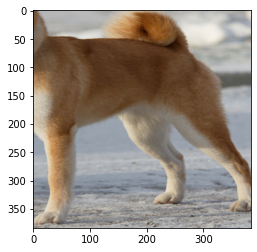

In [ ]:
plt.imshow((xb0[0].cpu()*torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).permute(1, 2, 0));

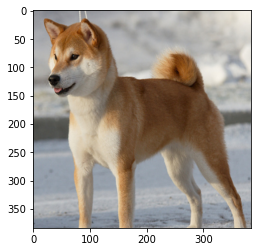

In [ ]:
plt.imshow((xb1[0].cpu()*torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).permute(1, 2, 0));

In [ ]:
def contrastive_loss(out_1, out_2):
    out_1 = F.normalize(out_1, dim=-1)
    out_2 = F.normalize(out_2, dim=-1)
    bs = out_1.size(0)
    temp = 0.25
    # [2*B, D]
    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temp)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * bs, device=sim_matrix.device)).bool()
    # [2B, 2B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * bs, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temp)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()

    center_loss = ((out_1 ** 2).sum(dim=1).mean() + (out_2 ** 2).sum(dim=1).mean())

    return loss + center_loss

In [ ]:
class CLCallback(Callback):
    def before_batch(self):
        self.learn.yb = tuple([self.xb[1]])
        self.learn.xb = tuple([self.xb[0]])
    def after_pred(self):
        self.learn.yb = tuple([self.learn.model(self.learn.yb[0])])

In [ ]:
model = timm.create_model('swin_base_patch4_window12_384', pretrained=True, num_classes = 0, in_chans = 3)
learn = Learner(dls, model, loss_func=contrastive_loss, cbs = CLCallback())
# learn.lr_find()
#learn.fine_tune(10, 1e-4)
learn.fit_one_cycle(10, 4e-5)

epoch,train_loss,valid_loss,time
0,2.291726,2.242736,09:32
1,2.274443,2.222449,09:33
2,2.240704,2.216578,09:33
3,2.225091,2.205528,09:34
4,2.237623,2.199224,09:32
5,2.214006,2.192206,09:32
6,2.191990,2.190123,09:34
7,2.197919,2.182683,09:33
8,2.201909,2.179859,09:33
9,2.174421,2.179723,09:32


In [ ]:
import faiss
def knn_score(train_set, test_set, n_neighbours=2):
    """
    Calculates the KNN distance
    """
    index = faiss.IndexFlatL2(train_set.shape[1])
    index.add(train_set)
    D, _ = index.search(test_set, n_neighbours)
    return np.sum(D, axis=1)

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
def get_score(model, train_loader, test_loader):
    train_feature_space = []
    with torch.no_grad():
        for (imgs, _, _) in tqdm(train_loader, desc='Train set feature extracting'):
            features = model(imgs)
            train_feature_space.append(features)
        train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
    test_feature_space = []
    test_labels = []
    with torch.no_grad():
        for (imgs, _, labels) in tqdm(test_loader, desc='Test set feature extracting'):
            features = model(imgs)
            test_feature_space.append(features)
            test_labels.append(labels)
        test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
        test_labels = torch.cat(test_labels, dim=0).cpu().numpy()

    distances = knn_score(train_feature_space, test_feature_space)

    auc = roc_auc_score(test_labels, distances)

    return auc, train_feature_space

In [ ]:
train_loader = dls.test_dl(train_files, with_labels=True)
test_loader = dls.test_dl(test_files + cat_files, with_labels=True)

In [ ]:
auc, _ = get_score(model, train_loader, test_loader)

In [ ]:
auc

0.878784548611111